In [1]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
import numpy as np
import scipy
import matplotlib.pyplot as plt
from qibo import hamiltonians

In [2]:
# set plot rcparams
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams["figure.figsize"] = [5, 3.50]
plt.rcParams["figure.autolayout"] = True

## Theoretical check

$$
H\otimes H e^{it Z\otimes Z}H\otimes H = X\otimes X ?
$$

Constructing a XX unitary and compare with one with ZZ.

In [3]:
# obtain e^{itX\otimes X} unitary
# Define the Pauli-X matrix
import scipy.linalg


X = np.array([[0, 1],
              [1, 0]], dtype=complex)

# Compute the tensor product X ⊗ X
XX = np.kron(X, X)

# Define the parameter t
t = np.pi / 6  # You can choose any real value for t

# Compute the unitary matrix U = e^{i t X⊗X}
U1 = scipy.linalg.expm(1j * t * XX)


In [4]:
# define the tensor hadamard unitary
H = 1/np.sqrt(2) * np.array([[1,1],
                             [1,-1]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)
HH = np.kron(H, H)
ZZ = np.kron(Z, Z)
U2 = HH @ scipy.linalg.expm(1j * t * ZZ) @ HH

In [5]:
np.linalg.norm(U1-U2)

9.496780065728157e-16

## Circuit implementation

From the above test, we see that theoretically, the decomposition is correct. Now we will build the pytket circuit for this decomposition.

According to the documentation: https://docs.quantinuum.com/h-series/trainings/getting_started/pytket_quantinuum/Quantinuum_arbitrary_angle_zz.html, the arbitrary angle ZZ gate in pytket is defined as
$$
RZZ(\alpha) = e^{-i\frac{\alpha}{2}Z\otimes Z}
$$

However, it is actually
$$
RZZ(\alpha) = e^{-i\frac{\alpha\pi}{2}Z\otimes Z}
$$

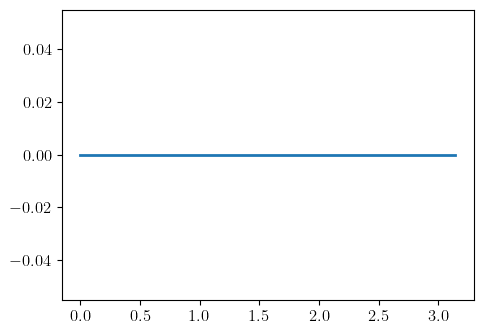

In [6]:
## RZZ in pytket
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    ZZ_evol = scipy.linalg.expm(1j * t * ZZ)
    c = Circuit(2)
    c.ZZPhase(-t*2/np.pi, 0, 1)
    diff.append(np.linalg.norm(ZZ_evol-c.get_unitary()))
    
plt.plot(t_range, diff)
    

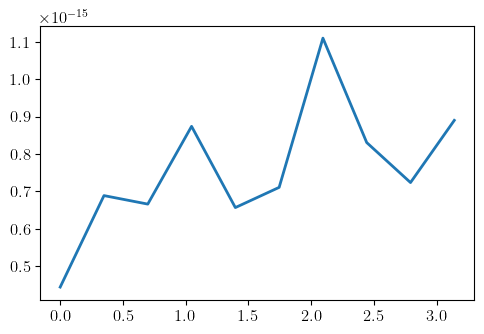

In [7]:
# compare our target circuit
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    U1 = scipy.linalg.expm(1j * t * XX)
    circuit1 = Circuit(2)
    circuit1.H(0)
    circuit1.H(1)
    circuit1.ZZPhase(-t*2/np.pi, 0, 1)
    circuit1.H(0)
    circuit1.H(1)
    U2 = circuit1.get_unitary()
    diff.append(np.linalg.norm(U1-U2))
plt.plot(t_range, diff)

## XXZ model

Now we will use native gates to simulate the XXZ hamiltonian given by
$$
H_ = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

Let's first consider the case with 2 qubit, since terms commute, the same strategy will apply to cases with more qubits.

Because the terms $X\otimes X$, $Y\otimes Y$, and $Z\otimes Z$ commute, we can write
$$
e^{it(XX+YY+ZZ)} = e^{itXX}e^{itYY}e^{itZZ}
$$

Then we have
$$
e^{itXX}=H\otimes H e^{itZZ}
$$
$$
e^{itYY}=(S\otimes S)(H\otimes H) e^{itZZ}(H\otimes H)(S^\dag\otimes S^\dag)
$$

Note that qibo.hamiltonians.XXZ for 2 qubits, there is an extra factor 2, that is QIBO_XXZ = 2 * XXZ.


Constructing an open boundary condition XXZ model (qibo XXZ uses periodic boundary condition)

In [8]:
from qibo.symbols import X, Y, Z
def construct_XXZ(nqubits, delta=0.5, boundary='closed'):
    if boundary == 'periodic' or boundary == 'closed':
        return hamiltonians.XXZ(nqubits, delta).matrix
    elif boundary == 'open':
        H_sym = sum([X(i)*X(i+1)+ Y(i)*Y(i+1) + delta* Z(i)*Z(i+1) for i in range(nqubits-1)])
        return hamiltonians.SymbolicHamiltonian(H_sym).matrix

### Construct 2 qubit XXZ

In [9]:
t = np.pi/6
delta = 0.5
H = construct_XXZ(2, delta, boundary='open')
U1 = scipy.linalg.expm(1j*t*H)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.13|INFO|2025-01-27 16:06:39]: Using qibojit (numba) backend on /CPU:0
[Qibo 0.2.13|WARNING|2025-01-27 16:06:39]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [10]:
t = np.pi/6
delta = 0.5
qc = Circuit(2)
# implement xx
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)

# implement yy
qc.Sdg(0), qc.Sdg(1)
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)
qc.S(0), qc.S(1)

# implement zz
qc.ZZPhase(-t*2/np.pi * delta, 0, 1)
U2 = qc.get_unitary()

In [11]:
# render_circuit_jupyter(qc)

In [12]:
np.linalg.norm(U1-U2)

1.486673200195252e-15

## Check for n qubits XXZ

In this section, we check that the product formula converges to n qubit XXZ model evolution with Trotter-Suzuki formula.
To do this, we divide the interaction into odd and even sub-lattices.
i.e. [1,2], [3,4], [5,6] being `c_odd` and [2,3], [4,5] being `c_even`.
This way, we can run the non-interacting pairs simultaneously.


In [13]:
def XX_interaction(qc, q0, q1, t):
    qc.H(q0), qc.H(q1)
    qc.ZZPhase(t*2/np.pi, q0, q1)
    qc.H(q0), qc.H(q1)

def YY_interaction(qc, q0, q1, t):
    qc.Sdg(q0), qc.Sdg(q1)
    XX_interaction(qc, q0, q1, t)
    qc.S(q0), qc.S(q1)

def ZZ_interaction(qc, q0, q1, t):
    qc.ZZPhase(t*2/np.pi, q0, q1)

We consider 2 ways of decomposing the XXZ terms:
1. 2 layers:
2. 3 layers

In [14]:
def XXZ_decomposition(nqubits, t, delta=0.5, qc=None, layer=2, boundary='closed'):
    # This function generates the circuit that simulates e^{itH}
    # where H is the XXZ model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        if boundary == 'periodic' or boundary == 'closed':
            # print('periodic case')
            if nqubits % 2 == 0:
                # even number of qubits add to odd pairs
                odd_starting_pairs.append([0, nqubits-1])
            else:
                even_starting_pairs.append([0, nqubits-1])
                # note that odd number of qubits result in degenerate ground states
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    if layer == 2:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
    elif layer == 3:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
    else:
        raise ValueError("Number of layers not supported, use either '2' or '3'.")
    return qc

In [15]:
XXZ_decomposition(3, np.pi/2)

[H q[0]; H q[1]; H q[2]; ZZPhase(1) q[0], q[1]; H q[0]; H q[1]; Sdg q[0]; Sdg q[1]; H q[0]; H q[1]; ZZPhase(1) q[0], q[1]; H q[0]; H q[1]; S q[0]; S q[1]; ZZPhase(0.5) q[0], q[1]; H q[0]; H q[1]; ZZPhase(1) q[0], q[2]; H q[0]; H q[2]; Sdg q[0]; Sdg q[2]; H q[0]; H q[2]; ZZPhase(1) q[0], q[2]; H q[0]; H q[2]; S q[0]; S q[2]; ZZPhase(0.5) q[0], q[2]; H q[2]; ZZPhase(1) q[1], q[2]; H q[1]; H q[2]; Sdg q[1]; Sdg q[2]; H q[1]; H q[2]; ZZPhase(1) q[1], q[2]; H q[1]; H q[2]; S q[1]; S q[2]; ZZPhase(0.5) q[1], q[2]; ]

Double check whether the tensor product approach gives the same unitary as QIBO model.

In [16]:
H_qibo = hamiltonians.XXZ(8, 0.5).matrix
H_tensor = construct_XXZ(8, 0.5, 'periodic')
print(np.linalg.norm(H_qibo - H_tensor))

0.0


Let's first fix the time and evaluate the error as we increase the number of qubits.

In [17]:
test_qubits = [2,3,4,5,6,7,8,9,10]
t = np.pi/6
U1 = [scipy.linalg.expm(-1j*t*(construct_XXZ(n,delta))) for n in test_qubits]
U2 = [XXZ_decomposition(n, t, delta).get_unitary() for n in test_qubits]
U3 = [XXZ_decomposition(n, t, delta, layer=3).get_unitary() for n in test_qubits]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_qubits))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_qubits))]

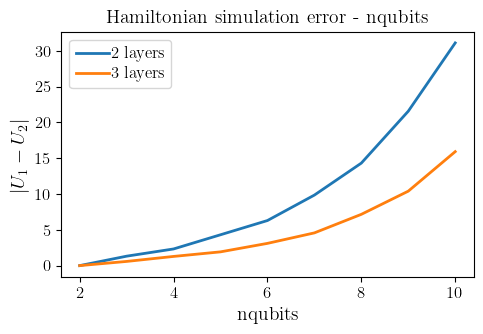

In [18]:
plt.plot(test_qubits, diff_12, label='2 layers')
plt.plot(test_qubits, diff_13, label='3 layers')
plt.xlabel('nqubits')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - nqubits')
plt.legend()

Now we fix nqubits and vary time.

In [19]:
nqubits = 8
test_t = np.linspace(0, 0.2, 30)
U1 = [scipy.linalg.expm(-1j*t*(construct_XXZ(nqubits,delta))) for t in test_t]
U2 = [XXZ_decomposition(nqubits, t, delta).get_unitary() for t in test_t]
U3 = [XXZ_decomposition(nqubits, t, delta, layer=3).get_unitary() for t in test_t]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_t))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_t))]

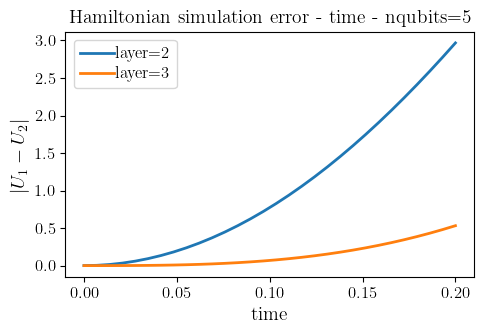

In [20]:
plt.plot(test_t, diff_12, label='layer=2')
plt.plot(test_t, diff_13, label='layer=3')
# plt.yscale('log')
plt.xlabel('time')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - time - nqubits=5')
plt.legend()

Next, we see how trotterization reduces the error when we fix the time.

In [21]:
t = np.pi/20
nqubits = 6
n_trotter = 10
U1 = scipy.linalg.expm(-1j*t*(construct_XXZ(nqubits, delta)))

In [22]:
def trotter_circuit(nqubits, t, n_trotter, layer=2):
    qc = Circuit(nqubits)
    dt = t/n_trotter
    for n in range(n_trotter):
        qc = XXZ_decomposition(nqubits, dt, delta, qc, layer=layer)
    return qc

In [23]:
U2 = [trotter_circuit(nqubits, t, n).get_unitary() for n in range(1, n_trotter)]
U3 = [trotter_circuit(nqubits, t, n, layer=3).get_unitary() for n in range(1, n_trotter)]
diff_12 = [np.linalg.norm(U1-U2[i]) for i in range(n_trotter-1)]
diff_13 = [np.linalg.norm(U1-U3[i]) for i in range(n_trotter-1)]

Text(0.5, 1.0, 'Hamiltonian simulation error - trotter steps')

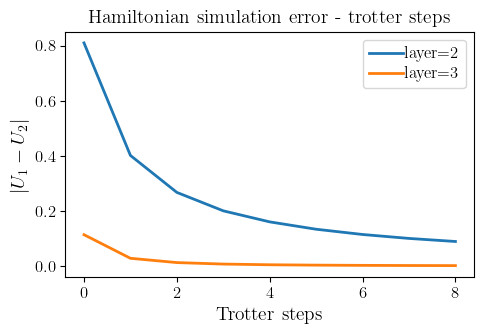

In [24]:
plt.plot(diff_12, label='layer=2')
plt.plot(diff_13, label='layer=3')
plt.legend()
plt.xlabel('Trotter steps')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - trotter steps')

## One step of DBQA

Now we have seen that using S, H, and ZZ gates, we are able to simulate the XXZ hamiltonian.

In the reduced group commutator notation, we denote $U$ as the VQE preconditioning unitary, 
the input Hamiltonian evolution $e^{-itH_0}$, and the diagonal evolution $ e^{itD}.

For one step of DBQA, 
$$
V_1 = e^{itD}U^\dagger e^{-itH_0}Ue^{-itD}
$$
and that
$$
A_1 = V_1^\dagger U^\dagger H_0 U V_1.
$$

With this we find
$$
\langle 0|A_1|0\rangle =\langle \psi_1|H_0|\psi\rangle
$$
where 
$$
|\psi\rangle = U* V_1|0\rangle.
$$

Therefore, our composed DBQA circuit should follow

$$
U_1 = U*V_1 = U_\theta e^{itD}U_\theta ^\dagger e^{-itH}U_\theta e^{-itD}
$$

In this example, we will use the closed boundary condition XXZ model with nqubits = 10.

In [39]:
# Create Hamiltonian
nqubits = 10
H = hamiltonians.models.XXZ(nqubits=nqubits, delta=0.5, dense=False)

In [ ]:
# Load the VQE circuit
import qibo
optimizer = 'sgd'
nqubits = nqubits
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ_step1.qasm'
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
vqe_circ_inverse = vqe_circ.dagger()
U = vqe_circ.get_unitary()
U_dag = U.T.conjugate()
# check unitary
print(np.linalg.norm(U@U_dag-np.eye(2**nqubits)))

4.48861701707973e-14


$$
U1 = U_\theta e^{itD}U_\theta ^\dagger e^{-itH}U_\theta e^{-itD}
$$

In [30]:
def unitary_expectation(H, U=None, ket0=None):
    if ket0 is None:
        ket0 = np.zeros((H.shape[0],), dtype=complex)
        ket0[0] = 1.0
    if U is None:
        psi = ket0
    else:
        psi = U @ ket0
    return np.vdot(psi, H @ psi).real

In [31]:
# Find optimal s
coef = [1]*nqubits
D_circ_qibo = hamiltonians.SymbolicHamiltonian(sum([coef[x]*Z(x) for x in range(nqubits)]))
s_space = np.linspace(0, 0.5, 100)
expect_ls = []
for s in s_space:
    d = D_circ_qibo.circuit(-s).unitary()
    d_dag = d.conjugate()
    h = scipy.linalg.expm(-1j*s*H.matrix)
    U1 = U @ d @ U_dag @ h @ U @ d_dag
    expect_ls.append(unitary_expectation(H.matrix, U1))

[Qibo 0.2.13|WARNING|2025-01-27 16:08:10]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


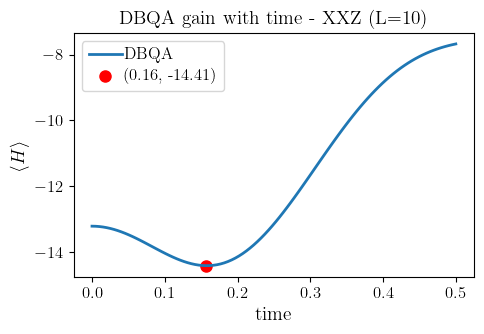

In [32]:
plt.plot(s_space, expect_ls, label='DBQA')
plt.title(f'DBQA gain with time - XXZ (L={nqubits})')
min_expect = min(expect_ls)
min_idx = expect_ls.index(min_expect)
s_min = s_space[min_idx]
plt.scatter(s_min, min_expect, color='red', label=f'{round(s_min,2), round(min_expect,2)}')
plt.xlabel('time')
plt.ylabel(r'$\langle H\rangle$')
plt.legend()

Now we will compose the circuit that executes the above unitary.
The first element is
$$
e^{-itD}
$$

Note that pytket $Rz(\alpha)=e^{-\frac{i}{2}\pi \alpha Z}$

In [33]:
def magnetic_field(coefs, t):
    # implments e^{-itD}
    nqubits = len(coefs)
    qc = Circuit(nqubits)
    
    for idx, coef in enumerate(coefs):
        theta = 2 * t * coef / np.pi
        qc.Rz(theta, idx)
    return qc    

# check for 1 qubit case
Z_matrix = np.array([[1, 0],
              [0, -1]], dtype=complex)
H1 = scipy.linalg.expm(-1j*0.4*Z_matrix)
H2 = magnetic_field([1], 0.4).get_unitary()
print(np.linalg.norm(H1-H2))

7.850462293418876e-17


In [34]:
# compose the circuit
from copy import deepcopy
t = s_min
sequence = [i for i in range(nqubits)]
D_circ = magnetic_field(coef, t)
D_circ_inverse = D_circ.dagger()
qc = deepcopy(D_circ)
qc.add_circuit(vqe_circ, sequence)
qc.add_circuit(XXZ_decomposition(nqubits, t, layer=3, boundary='periodic'), sequence)
qc.add_circuit(vqe_circ_inverse, sequence)
qc.add_circuit(D_circ_inverse, sequence)
qc.add_circuit(vqe_circ, sequence)
# render_circuit_jupyter(qc)

[Rz(0.0996728) q[0]; Rz(0.0996728) q[1]; Rz(0.0996728) q[2]; Rz(0.0996728) q[3]; Rz(0.0996728) q[4]; Rz(0.0996728) q[5]; Rz(0.0996728) q[6]; Rz(0.0996728) q[7]; Rz(0.0996728) q[8]; Rz(0.0996728) q[9]; Ry(0.862207) q[0]; Ry(2.806) q[1]; Ry(0.136941) q[2]; Ry(0.794857) q[3]; Ry(3.92631) q[4]; Ry(3.72971) q[5]; Ry(2.9185) q[6]; Ry(0.473874) q[7]; Ry(3.33275) q[8]; Ry(3.05626) q[9]; Rz(0.0274873) q[0]; Rz(0.934314) q[1]; Rz(3.53078) q[2]; Rz(3.65149) q[3]; Rz(0.989573) q[4]; Rz(0.331581) q[5]; Rz(0.282625) q[6]; Rz(3.53893) q[7]; Rz(1.15929) q[8]; Rz(0.737963) q[9]; CZ q[0], q[1]; CZ q[2], q[3]; CZ q[4], q[5]; CZ q[6], q[7]; CZ q[8], q[9]; Ry(0.481395) q[0]; Ry(2.88679) q[1]; Ry(3.72033) q[2]; Ry(0.477334) q[3]; Ry(3.69321) q[4]; Ry(3.99198) q[5]; Ry(0.650632) q[6]; Ry(0.278702) q[7]; Ry(0.477231) q[8]; Ry(0.2436) q[9]; Rz(0.989798) q[0]; Rz(3.95585) q[1]; Rz(1.13817) q[2]; Rz(3.82296) q[3]; Rz(2.99765) q[4]; Rz(3.67467) q[5]; Rz(3.00584) q[6]; Rz(0.495642) q[7]; Rz(2.79765) q[8]; Rz(0.028

In [35]:
# check the unitary
d = D_circ_qibo.circuit(-s_min).unitary()
d_dag = d.conjugate()
h = scipy.linalg.expm(-1j*s_min*H.matrix)
U1 = U @ d @ U_dag @ h @ U @ d_dag
np.linalg.norm(qc.get_unitary() - U1)

0.5812005564468012

In [37]:
ket0 = H.backend.zero_state(nqubits)
target_energy = np.real(np.min(np.asarray(H.eigenvalues())))
vqe_energy = unitary_expectation(H.matrix, U, ket0)
dbqa_energy = unitary_expectation(H.matrix, U1, ket0)
dbqa_circuit_energy = unitary_expectation(H.matrix, qc.get_unitary(), ket0)
print('Target enegry:', target_energy)
print('Initial energy:', unitary_expectation(H.matrix))
print('VQE energy:', vqe_energy)
print('DBQA energy (analytical):', dbqa_energy)
print('DBQA energy (circuit):', dbqa_circuit_energy)

Target enegry: -15.276131122065763
Initial energy: 5.0
VQE energy: -13.212235088351669
DBQA energy (analytical): -14.412054168137596
DBQA energy (circuit): -14.40698683874857


In [38]:
print("Circuit depth:", qc.depth())
print("Circuit total gate count:", qc.n_gates)
num_cnots = sum(1 for command in qc if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

Circuit depth: 50
Circuit total gate count: 425
Circuit CNOT count: 0


# Execution on Quantinuum

In [42]:
import qnexus as qnx
from quantinuum_demo.quantinuum_utils import *

In [43]:
# connect to nexus account
qnx.client.auth.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      JtJFRG                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=JtJFRGMCQeMNtim1utfqPZdTU1uIVMcOOzR1Q3MNT3PWeyZIsGnvN_w0kE9jTEA_ES0UHKGksepk4byj0CI0wg
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [44]:
# connect to nexus project
project_name = "DBQA_native_gates"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

In [45]:
# XXZ model (periodic)
nqubits = nqubits
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

In [46]:
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)
# for mc in measurement_setup.measurement_circs:
#     render_circuit_jupyter(mc)

### Circuit compilation

In [47]:
optimisation_level = 2
# create list of circuits for measurement in different bases
vqe_circuit_ref_list = []
gci_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = vqe_circ.copy()
    c.append(mc)
    measurement_vqe_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement vqe circuit {i}",
            )
    c = qc.copy()
    c.append(mc)
    measurement_gci_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement gci circuit {i}",
            )
    vqe_circuit_ref_list.append(measurement_vqe_circuit_ref)
    gci_circuit_ref_list.append(measurement_gci_circuit_ref)

# compile vqe measurement circuit list
compiled_vqe_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}",
            circuits=vqe_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# compile gci measurement circuit list
compiled_gci_circuit_refs = qnx.compile(
            name=f"compile_job_GCI_{datetime.now()}",
            circuits=gci_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

### Noiseless execution

In [48]:
# Configuration
nshots = 2000
backend_config = qnx.QuantinuumConfig(device_name="H1-1LE")
vqe_job_name = f"execute_job_VQE_{nshots}shots_{datetime.now()}"
gci_job_name = f"execute_job_GCI_{nshots}shots_{datetime.now()}"
results_vqe = qnx.start_execute_job(
            name=vqe_job_name,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci = qnx.start_execute_job(
            name=gci_job_name,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [49]:
from pathlib import Path
import os
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe,
    path=Path.cwd() / folder_path / vqe_job_name,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci,
    path=Path.cwd() /folder_path / gci_job_name,
    mkdir=True,
)

In [67]:
# noiseless results
print(qnx.jobs.status(results_vqe))
print(qnx.jobs.status(results_gci))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 1, 27, 8, 44, 31, 413135, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 1, 27, 8, 41, 6, 776163, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 1, 27, 8, 44, 5, 631385, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 1, 27, 8, 46, 6, 56785, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 1, 27, 8, 41, 7, 322851, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 1, 27, 8, 44, 31, 927381, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)


In [68]:
vqe_results = [job.download_result() for job in qnx.jobs.results(results_vqe)]
gci_results = [job.download_result() for job in qnx.jobs.results(results_gci)]

In [69]:
expval_vqe = compute_expectation_value_from_results(
    vqe_results, measurement_setup, ham_quantinuum
)
print(expval_vqe)
expval_gci = compute_expectation_value_from_results(
    gci_results, measurement_setup, ham_quantinuum
)
print(expval_gci)

-13.008499999999998
-14.408500000000002


### Noisy execution

In [70]:
backend_config = qnx.QuantinuumConfig(
    device_name='H1-Emulator',
    attempt_batching=True,
)
nshots = 2000

In [60]:
vqe_job_name_with_noise = f"execute_job_VQE_{nshots}shots_noise_{datetime.now()}"
gci_job_name_with_noise = f"execute_job_GCI_{nshots}shots_noise_{datetime.now()}"
results_vqe_noise = qnx.start_execute_job(
            name=vqe_job_name_with_noise,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci_noise = qnx.start_execute_job(
            name=gci_job_name_with_noise,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [61]:
from pathlib import Path
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ_native/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe_noise,
    path=Path.cwd() / folder_path / vqe_job_name_with_noise,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci_noise,
    path=Path.cwd() / folder_path / gci_job_name_with_noise,
    mkdir=True,
)

In [71]:
print(qnx.jobs.status(results_vqe_noise))
print(qnx.jobs.status(results_gci_noise))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 1, 27, 8, 46, 10, 347793, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 1, 27, 8, 43, 32, 211015, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 1, 27, 8, 46, 6, 152270, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 1, 27, 8, 46, 20, 667749, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 1, 27, 8, 43, 32, 543386, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 1, 27, 8, 46, 10, 702217, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)

In [72]:
vqe_results_noise = [job.download_result() for job in qnx.jobs.results(results_vqe_noise)]
gci_results_noise = [job.download_result() for job in qnx.jobs.results(results_gci_noise)]

In [73]:
expval_vqe_noise = compute_expectation_value_from_results(
    vqe_results_noise, measurement_setup, ham_quantinuum
)
print(expval_vqe_noise)
expval_gci_noise = compute_expectation_value_from_results(
    gci_results_noise, measurement_setup, ham_quantinuum
)
print(expval_gci_noise)

-12.999999999999993
-13.780499999999996


## Prepare report

In [130]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [131]:
qibo.set_backend("numpy")

[Qibo 0.2.13|INFO|2025-01-27 14:59:22]: Using numpy backend on /CPU:0


In [ ]:
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
with open (vqe_circ_file, "r") as file:
    vqe_circuit_qasm_str = file.read()
    
with open (gci_circ_file, "r") as file:
    gci_circuit_qasm_str = file.read()